####E. Build a Logistic Regression Model

**Initiate new Spark session.**

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Employee_Attrition_Part_2').getOrCreate()

**Import numpy, pandas, and data visualization libraries.**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Import churn modeling CSV file into PySpark dataframe called churn_model2.**

In [7]:
churn_model2 = spark.read.csv('/FileStore/tables/churn_modeling_data.csv', inferSchema=True, header=True)

**Check number of rows and columns in churn_model2 dataframe.**

In [9]:
print(churn_model2.count(), len(churn_model2.columns))

1470 11

**View structure of churn_model2 dataframe.**

In [11]:
churn_model2.printSchema()

root
-- Churn: integer (nullable = true)
-- Age: integer (nullable = true)
-- DistanceFromHome: integer (nullable = true)
-- EnvironmentSatisfaction: integer (nullable = true)
-- JobInvolvement: integer (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- StockOptionLevel: integer (nullable = true)
-- Sales_Rep: integer (nullable = true)
-- Single: integer (nullable = true)
-- BusTravLevel: integer (nullable = true)
-- Overtime_Dum: integer (nullable = true)

**View first five rows of churn_model2 dataframe.**

In [13]:
display(churn_model2.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,41,1,1,2,5993,0,0,1,1,1
0,49,8,2,1,5130,1,0,0,2,0
1,37,2,3,1,2090,0,0,1,1,1
0,33,3,3,2,2909,0,0,0,2,1
0,27,2,0,2,3468,1,0,0,1,0


**Convert predictor features into vector column using VectorAssembler.**

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [16]:
assembler = VectorAssembler(inputCols=['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum'], outputCol='features')

In [17]:
churn_model2_vect = assembler.transform(churn_model2)
display(churn_model2_vect.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features
1,41,1,1,2,5993,0,0,1,1,1,"List(1, 10, List(), List(41.0, 1.0, 1.0, 2.0, 5993.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
0,49,8,2,1,5130,1,0,0,2,0,"List(1, 10, List(), List(49.0, 8.0, 2.0, 1.0, 5130.0, 1.0, 0.0, 0.0, 2.0, 0.0))"
1,37,2,3,1,2090,0,0,1,1,1,"List(1, 10, List(), List(37.0, 2.0, 3.0, 1.0, 2090.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
0,33,3,3,2,2909,0,0,0,2,1,"List(1, 10, List(), List(33.0, 3.0, 3.0, 2.0, 2909.0, 0.0, 0.0, 0.0, 2.0, 1.0))"
0,27,2,0,2,3468,1,0,0,1,0,"List(1, 10, List(), List(27.0, 2.0, 0.0, 2.0, 3468.0, 1.0, 0.0, 0.0, 1.0, 0.0))"


**Decide which random state seed number will provide the highest area under the ROC curve (AUC).**

In [19]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [20]:
logreg = LogisticRegression(featuresCol='features', labelCol='Churn')
roc_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Churn')

In [21]:
number_range = range(100, 111)

auc_scores = []

for number in number_range:
  train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=number)
  lr1_model = logreg.fit(train_model_data)
  lr1_predictions = lr1_model.transform(test_model_data)
  auc_scores.append(roc_eval.evaluate(lr1_predictions))

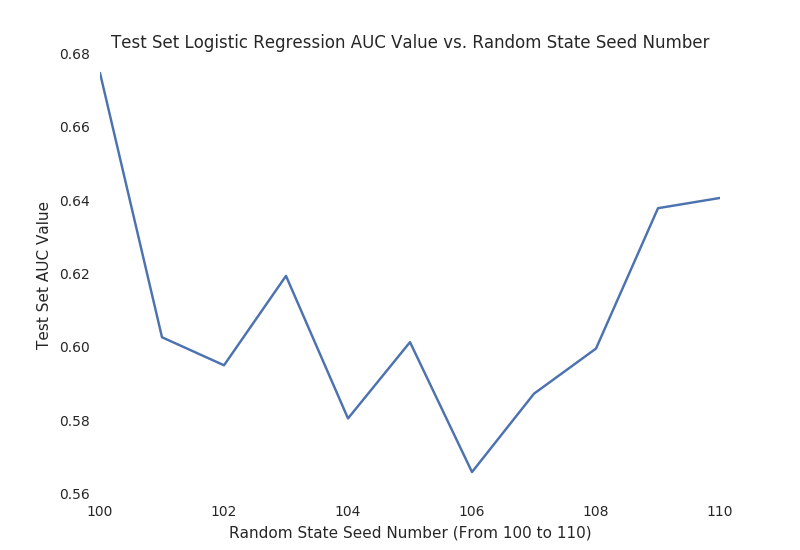

In [22]:
auc_seed, ax = plt.subplots()
ax.plot(number_range, auc_scores)
ax.set_xlabel('Random State Seed Number (From 100 to 110)')
ax.set_ylabel('Test Set AUC Value')
ax.set_title('Test Set Logistic Regression AUC Value vs. Random State Seed Number')
display(auc_seed)

In [23]:
dict(zip(number_range, auc_scores))

Out[ 14 ]: 
{100: 0.6751059367375765,
 101: 0.603022759601707,
 102: 0.5953754300748836,
 103: 0.6197577622598336,
 104: 0.5808826291079812,
 105: 0.6016876331889737,
 106: 0.5662603069396773,
 107: 0.5876353276353277,
 108: 0.5999358871614041,
 109: 0.6382195575456304,
 110: 0.6410164638511096}

* 100 is the random state seed number that will produce the highest AUC value.

**Split churn / attrition modeling data into training and test sets.**

In [26]:
train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=100)

In [27]:
print(churn_model2_vect.count(), len(churn_model2_vect.columns))
print(train_model_data.count(), len(train_model_data.columns))
print(test_model_data.count(), len(test_model_data.columns))

1470 12
1026 12
444 12

**Fit a logistic regression model on training data set.**

In [29]:
lr2_model = logreg.fit(train_model_data)

**Print training set logistic regression model intercept and coefficients.**

In [31]:
feature_cols = ['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum']
print('Intercept: ' + str(lr2_model.intercept))
dict(zip(feature_cols, lr2_model.coefficients))

Intercept: -0.3902961627334016
 Out[ 18 ]: 
{'EnvironmentSatisfaction': -0.38690689052095001,
 'Single': 0.65486481930895946,
 'Sales_Rep': 0.86028031086763734,
 'Age': -0.031408492109050362,
 'BusTravLevel': 0.69976884989104071,
 'MonthlyIncome': -9.1392196394833402e-05,
 'DistanceFromHome': 0.032820771975183946,
 'JobInvolvement': -0.4877065112447489,
 'StockOptionLevel': -0.17540156220929207,
 'Overtime_Dum': 1.4674876518479081}

**Express training set logistic regression model coefficients as odds.**

In [33]:
dict(zip(feature_cols, np.exp(lr2_model.coefficients)))

Out[ 19 ]: 
{'EnvironmentSatisfaction': 0.67915432768845196,
 'Single': 1.9248822928695728,
 'Sales_Rep': 2.3638232061805993,
 'Age': 0.96907963082965476,
 'BusTravLevel': 2.0132872821063619,
 'MonthlyIncome': 0.99990861197974468,
 'DistanceFromHome': 1.0333653146188271,
 'JobInvolvement': 0.61403305839832822,
 'StockOptionLevel': 0.83911999422643191,
 'Overtime_Dum': 4.3383220626594401}

**Print training set AUC value.**

In [35]:
trainingSummary = lr2_model.summary
print('Training Set Area Under ROC Curve: ', str(trainingSummary.areaUnderROC))

Training Set Area Under ROC Curve: 0.7928342245989302

**Plot training set logistic regression model ROC curve.**

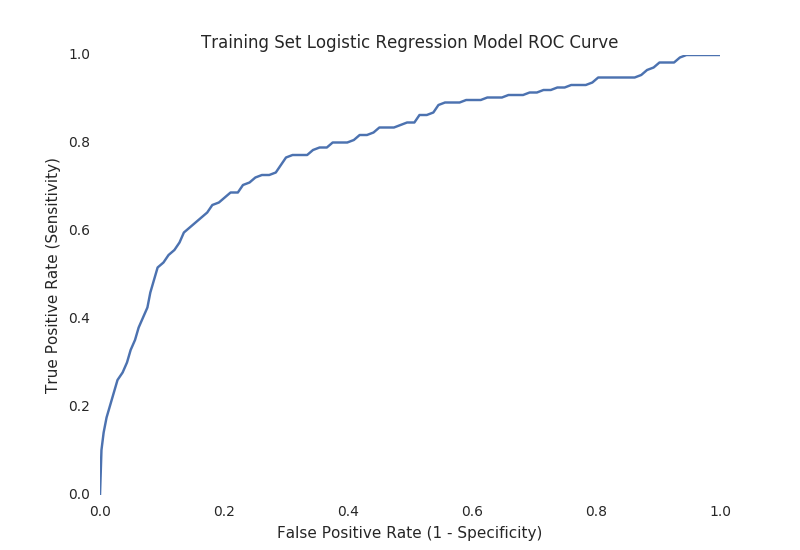

In [37]:
train_roc = trainingSummary.roc.toPandas()
roc_curve, ax = plt.subplots()
ax.plot(train_roc['FPR'], train_roc['TPR'])
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_title('Training Set Logistic Regression Model ROC Curve')
display(roc_curve)

**Plot training set logistic regression precision-recall curve.**

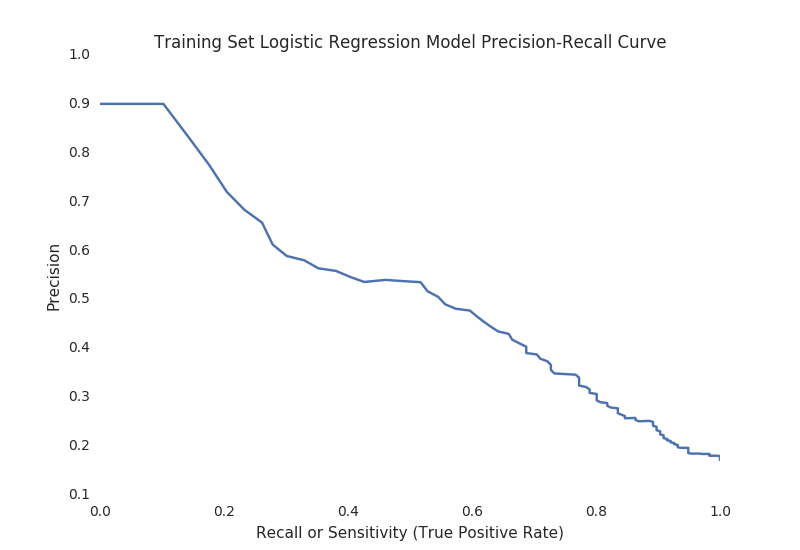

In [39]:
train_pr = trainingSummary.pr.toPandas()
pr_curve, ax = plt.subplots()
ax.plot(train_pr['recall'], train_pr['precision'])
ax.set_xlabel('Recall or Sensitivity (True Positive Rate)')
ax.set_ylabel('Precision')
ax.set_title('Training Set Logistic Regression Model Precision-Recall Curve')
display(pr_curve)

**Make predictions on test data set and calculate test set AUC value.**

In [41]:
lr2_predictions = lr2_model.transform(test_model_data)
print('Test Set Area Under ROC Curve: ', roc_eval.evaluate(lr2_predictions))

Test Set Area Under ROC Curve: 0.6751059367375765

**Compute test set null accuracy manually.**

In [43]:
from pyspark.sql.functions import col, avg
lr2_predictions.agg(1 - avg(col('Churn'))).show()

+------------------+
 (1 - avg(Churn))|
+------------------+
0.8626126126126126|
+------------------+

**Calculate test set accuracy and error rates.**

In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [46]:
acc_eval = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')
print('Test Set Accuracy: ', acc_eval.evaluate(lr2_predictions))
print('Test Set Error Rate: ', 1 - acc_eval.evaluate(lr2_predictions))

Test Set Accuracy: 0.9031531531531531
Test Set Error Rate: 0.09684684684684686

**Calculate number of true negatives, false positives, false negatives, and true positives in test data set, which is all four figures that comprise a confusion matrix.**

In [48]:
print('True Negatives: ', lr2_predictions.filter((lr2_predictions['Churn'] == 0) & (lr2_predictions['prediction'] == 0)).count())
print('False Positives: ', lr2_predictions.filter(lr2_predictions['Churn'] < lr2_predictions['prediction']).count())
print('False Negatives: ', lr2_predictions.filter(lr2_predictions['Churn'] > lr2_predictions['prediction']).count())
print('True Positives: ', lr2_predictions.filter((lr2_predictions['Churn'] == 1) & (lr2_predictions['prediction'] == 1)).count())

True Negatives: 379
False Positives: 4
False Negatives: 39
True Positives: 22

**Manually calculate accuracy and misclassification / error rate, precision, recall / sensitivity, and specificity.**

In [50]:
print('Accuracy: ', float(379 + 22) / float(379 + 4 + 39 + 22))
print('Misclassification / Error Rate: ', float(4 + 39) / float(379 + 4 + 39 + 22))
print('Precision: ', float(22) / float(4 + 22))
print('Recall / Sensitivity: ', float(22) / float(39 + 22))
print('Specificity: ', float(379) / float(379 + 4))

Accuracy: 0.9031531531531531
Misclassification / Error Rate: 0.09684684684684684
Precision: 0.8461538461538461
Recall / Sensitivity: 0.36065573770491804
Specificity: 0.9895561357702349

* Precision measures how confident the training set logistic regression model captures the positives. Recall / sensitivity measures how well the training set logistic regression model captures the positives. Specificity measures how well the training set logistic regression model captures the negatives.

**List out false positives in test data set.**

In [53]:
targ_feat_cols = ['Churn', 'prediction', 'Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum']
display(lr2_predictions.filter(lr2_predictions['Churn'] < lr2_predictions['prediction']).select(targ_feat_cols))

Churn,prediction,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
0,1.0,34,7,1,2,2308,1,1,0,1,1
0,1.0,34,22,2,1,5747,0,0,0,2,1
0,1.0,35,2,0,1,4930,0,0,1,2,1
0,1.0,36,2,2,2,2644,0,1,1,1,1


**List out false negatives in test data set.**

In [55]:
display(lr2_predictions.filter(lr2_predictions['Churn'] > lr2_predictions['prediction']).select(targ_feat_cols))

Churn,prediction,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,0.0,19,2,0,1,2564,0,0,1,1,0
1,0.0,20,2,2,1,2044,0,1,1,1,0
1,0.0,21,10,2,1,1416,0,0,1,1,0
1,0.0,21,12,2,3,2716,0,1,1,1,0
1,0.0,22,3,1,2,4171,1,0,0,1,1
1,0.0,24,1,1,2,2293,1,0,0,1,1
1,0.0,26,21,0,2,2377,1,0,0,1,0
1,0.0,28,5,2,2,3441,0,0,1,1,1
1,0.0,28,13,3,2,9854,0,0,1,1,1
1,0.0,28,24,1,1,8722,0,0,1,0,0


**To change predicted probability threshold to balance sensitivity and specificity, extract predicted probability of churn for each employee from vectorized probability column and generate new predicted class based off new threshold.**

In [57]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
second_vec_element = udf(lambda v: float(v[1]), FloatType())

In [58]:
lr2_pred_prob = lr2_predictions.withColumn('pred_prob', second_vec_element(lr2_predictions['probability'])).withColumn('pred_class', F.when(col('pred_prob') > 0.15, 1).otherwise(0))
display(lr2_pred_prob.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features,rawPrediction,probability,prediction,pred_prob,pred_class
0,19,3,1,2,1483,0,0,1,1,0,"List(1, 10, List(), List(19.0, 3.0, 1.0, 2.0, 1483.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(1.0318160679437924, -1.0318160679437924))","List(1, 2, List(), List(0.7372678269674335, 0.2627321730325665))",0.0,0.2627321779727936,1
0,20,1,3,1,2836,0,0,1,1,0,"List(1, 10, List(), List(20.0, 1.0, 3.0, 1.0, 2836.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(1.5386270155225712, -1.5386270155225712))","List(1, 2, List(), List(0.8232650450336783, 0.1767349549663218))",0.0,0.17673495411872864,1
0,20,2,2,2,2783,0,1,1,1,0,"List(1, 10, List(), List(20.0, 2.0, 2.0, 2.0, 2783.0, 0.0, 1.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(0.7414817669946226, -0.7414817669946226))","List(1, 2, List(), List(0.6773197928655361, 0.32268020713446394))",0.0,0.32268020510673523,1
0,20,3,0,1,3033,0,0,1,1,0,"List(1, 10, List(), List(20.0, 3.0, 0.0, 1.0, 3033.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(0.3302690626991355, -0.3302690626991355))","List(1, 2, List(), List(0.5818248425007234, 0.41817515749927664))",0.0,0.4181751608848572,1
0,21,5,2,2,3117,0,0,1,1,0,"List(1, 10, List(), List(21.0, 5.0, 2.0, 2.0, 3117.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(1.5652332476416326, -1.5652332476416326))","List(1, 2, List(), List(0.8271030079064045, 0.1728969920935954))",0.0,0.17289699614048004,1


**Using new threshold, calculate number of true negatives, false positives, false negatives, and true positives in test data set, which is all four figures that comprise a confusion matrix.**

In [60]:
print('True Negatives: ', lr2_pred_prob.filter((lr2_pred_prob['Churn'] == 0) & (lr2_pred_prob['pred_class'] == 0)).count())
print('False Positives: ', lr2_pred_prob.filter(lr2_pred_prob['Churn'] < lr2_pred_prob['pred_class']).count())
print('False Negatives: ', lr2_pred_prob.filter(lr2_pred_prob['Churn'] > lr2_pred_prob['pred_class']).count())
print('True Positives: ', lr2_pred_prob.filter((lr2_pred_prob['Churn'] == 1) & (lr2_pred_prob['pred_class'] == 1)).count())

True Negatives: 269
False Positives: 114
False Negatives: 14
True Positives: 47

**Manually calculate recall / sensitivity and specificity, and check whether sensitivity and specificity are balanced with one another.**

In [62]:
print('Recall / Sensitivity: ', float(47) / float(14 + 47))
print('Specificity: ', float(269) / float(269 + 114))

Recall / Sensitivity: 0.7704918032786885
Specificity: 0.7023498694516971

* 0.15 is the best predicted probability threshold to balance sensitivity and specificity with one another.

**Generate training set logistic regression models using 10-fold cross-validation.**

In [65]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [66]:
paramGrid = (ParamGridBuilder().addGrid(logreg.regParam, [0.01, 0.5, 2.0]).addGrid(logreg.elasticNetParam, [0.0, 0.5, 1.0]).addGrid(logreg.maxIter, [1, 5, 10]).build())
cv = CrossValidator(estimator=logreg, estimatorParamMaps=paramGrid, evaluator=roc_eval, numFolds=10)
cv_lr_model = cv.fit(train_model_data)

**Compute test set accuracy and AUC value for best cross-validation model.**

In [68]:
cv_predictions = cv_lr_model.transform(test_model_data)
print('Best Cross-Validation Test Set Logistic Regression Model Metrics')
print('Test Set Accuracy: ', acc_eval.evaluate(cv_predictions))
print('Test Set Area Under ROC Curve: ', roc_eval.evaluate(cv_predictions))

Best Cross-Validation Test Set Logistic Regression Model Metrics
Test Set Accuracy: 0.8963963963963963
Test Set Area Under ROC Curve: 0.6436245345203955